# Importing Packages

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
from torch.utils.data import Dataset, DataLoader
import glob
import cv2 as cv
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from torchvision import models, transforms, datasets

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(f'Device is {device}')

Device is cuda


# Custom Dataset Preparation

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, data_path):
    self.imgs_path = data_path
    file_list = glob.glob(self.imgs_path + '/*')
    self.data = []
    for class_path in file_list:
      class_name = int(class_path.split("/")[-1][-1])
      for image in glob.glob(class_path +"/*.jpg"):
        self.data.append([image, class_name])
    self.image_size = (224,224)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    image, class_name = self.data[idx]
    image = cv.imread(image)
    image = cv.resize(image, self.image_size)
    image_tensor = torch.from_numpy(image)
    image_tensor = image_tensor.permute(2,0,1)
    class_id = torch.tensor(class_name)

    return image_tensor, class_id



In [ ]:
training_path = 'data/training'
testing_path = 'data/validation'
train_data = CustomDataset(training_path)
test_data = CustomDataset(testing_path)

In [ ]:
train_batch_size = 16
test_batch_size = 16

In [ ]:
train_loader = DataLoader(train_data, batch_size = train_batch_size, shuffle = True)
test_loader = DataLoader(test_data, batch_size = test_batch_size, shuffle = True)

# Custom Architecture for Monkey classification

### Neural Network

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 3)
    self.pool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 12, kernel_size = 3)
    self.pool2 = nn.MaxPool2d(2)
    self.conv3 = nn.Conv2d(in_channels = 12, out_channels = 16, kernel_size = 3)
    self.pool3 = nn.MaxPool2d(2)
    self.conv4 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3)
    self.pool4 = nn.MaxPool2d(2)
    self.conv5 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3)
    self.pool5 = nn.MaxPool2d(2)
    self.fc1 = nn.Linear(1600,120)
    self.fc2 = nn.Linear(120,10)


  def forward(self, x):
    out1 = self.pool1(F.relu(self.conv1(x)))
    out2 = self.pool2(F.relu(self.conv2(out1)))
    out3 = self.pool3(F.relu(self.conv3(out2)))
    out4 = self.pool4(F.relu(self.conv4(out3)))
    out5 = self.pool5(F.relu(self.conv5(out4)))
    out5 = out5.reshape(out5.shape[0], -1)
    out6 = F.relu(self.fc1(out5))
    out7 = F.relu(self.fc2(out6))
    
    return F.softmax(out7, dim=1)


### Model Initiliazation

In [ ]:
model = CNN()
model.to(device)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1600, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)

### Hyperparameter

In [ ]:
n_epoch = 100
learning_rate = 10e-5
criterion  = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)


### Training Loop

In [ ]:
def train():

  model.train()
  train_error = []
  
  for epoch in range(n_epoch):
    total_loss = 0
    n_batches = 0
    for i, (images, labels) in enumerate(train_loader):

      n_batches += 1

      images = images.float()
      images = images.to(device)
      labels = labels.type(torch.LongTensor)
      labels = labels.to(device)

      output = model(images)
      loss = criterion(output, labels)
      total_loss += loss.item()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    
    avg_loss = total_loss/n_batches
    train_error.append(avg_loss)
    clear_output(wait = True)
    plt.plot(train_error)
    plt.xlabel('Epoch')
    plt.ylabel('Training Error')
    plt.title('Training Error vs Epoch')
    plt.show()
    print(f'Epoch [{epoch}/{n_epoch}], Loss : {avg_loss:.3f}')

  return train_error

### Testing Loop

In [ ]:
train_error = train()

In [ ]:
def test():
  with torch.no_grad():
    model.eval()
    n_correct = 0
    n_total = 0

    for i, (images,labels) in enumerate(test_loader):
      images = images.to(device).float()
      labels = labels.to(device)
      output = model(images)
      predict = output.argmax(dim=1)
      n_correct += (predict == labels).sum().item()
      n_total += len(labels)

  print(f'Test Accuracy: {n_correct*100/n_total}')
  

In [ ]:
test()

# Transfer Learning with only classification (FC) parameter tuning

### Loading pretraining ResNet

In [ ]:
model = models.resnet34(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

### Freezing convolutional layer weight

In [ ]:
for name, param in model.named_parameters():
  if 'fc' in name:
    continue
  param.requires_grad = False

### Modifying last layer

In [ ]:
num_feature = model.fc.in_features
model.fc = nn.Linear(num_feature,10)

### Hyperparameter

In [ ]:
n_epoch = 100
learning_rate = 10e-5

### Initializing Network

In [ ]:
model.to(device)
criterion  = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

### Training Loop

In [ ]:
def train():

  model.train()
  train_error = []
  
  for epoch in range(n_epoch):
    total_loss = 0
    n_batches = 0
    for i, (images, labels) in enumerate(train_loader):

      n_batches += 1

      images = images.float()
      images = images.to(device)
      labels = labels.type(torch.LongTensor)
      labels = labels.to(device)

      output = model(images)
      loss = criterion(output, labels)
      total_loss += loss.item()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    
    avg_loss = total_loss/n_batches
    train_error.append(avg_loss)
    clear_output(wait = True)
    plt.plot(train_error)
    plt.xlabel('Epoch')
    plt.ylabel('Training Error')
    plt.title('Training Error vs Epoch')
    plt.show()
    print(f'Epoch [{epoch}/{n_epoch}], Loss : {avg_loss:.3f}')

  return train_error

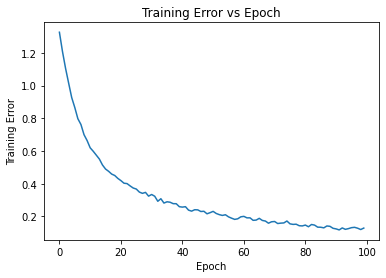

Epoch [99/100], Loss : 0.128


In [ ]:
train_error = train()

### Testing Loop

In [ ]:
def test():
  with torch.no_grad():
    model.eval()
    n_correct = 0
    n_total = 0

    for i, (images,labels) in enumerate(test_loader):
      images = images.to(device).float()
      labels = labels.to(device)
      output = model(images)
      predict = output.argmax(dim=1)
      n_correct += (predict == labels).sum().item()
      n_total += len(labels)

  print(f'Test Accuracy: {n_correct*100/n_total}')

In [ ]:
test()

Test Accuracy: 95.58823529411765


# Transfer Learning with all layer parameter tuning

### Loading Pretrained Model

In [ ]:
model = models.resnet34(pretrained=True)

### Modifying last layer

In [ ]:
num_feature = model.fc.in_features
model.fc = nn.Linear(num_feature,10)

### Hyperparameter

In [ ]:
n_epoch = 100
learning_rate = 10e-5

### Initializing Model

In [ ]:
model.to(device)
criterion  = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

### Training Loop

In [ ]:
def train():

  model.train()
  train_error = []
  
  for epoch in range(n_epoch):
    total_loss = 0
    n_batches = 0
    for i, (images, labels) in enumerate(train_loader):

      n_batches += 1

      images = images.float()
      images = images.to(device)
      labels = labels.type(torch.LongTensor)
      labels = labels.to(device)

      output = model(images)
      loss = criterion(output, labels)
      total_loss += loss.item()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    
    avg_loss = total_loss/n_batches
    train_error.append(avg_loss)
    clear_output(wait = True)
    plt.plot(train_error)
    plt.xlabel('Epoch')
    plt.ylabel('Training Error')
    plt.title('Training Error vs Epoch')
    plt.show()
    print(f'Epoch [{epoch}/{n_epoch}], Loss : {avg_loss:.3f}')

  return train_error

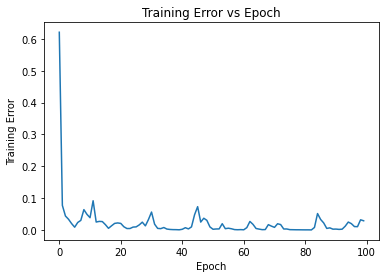

Epoch [99/100], Loss : 0.029


In [ ]:
train_error = train()

### Testing Loop

In [ ]:
def test():
  with torch.no_grad():
    model.eval()
    n_correct = 0
    n_total = 0

    for i, (images,labels) in enumerate(test_loader):
      images = images.to(device).float()
      labels = labels.to(device)
      output = model(images)
      predict = output.argmax(dim=1)
      n_correct += (predict == labels).sum().item()
      n_total += len(labels)

  print(f'Test Accuracy: {n_correct*100/n_total}')

In [ ]:
test()

Test Accuracy: 95.58823529411765
